In [171]:
# Source - https://www.kaggle.com/code/rahuldshetty/conditional-gan-for-mnist/notebook

In [172]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import tensorflow as tf 

In [173]:
from keras.models import Sequential, Model 
from keras.layers import Flatten, Conv2D, Conv2DTranspose, Dense, BatchNormalization, Reshape
from keras.layers import Input, Embedding, ReLU, LeakyReLU, Dropout, Concatenate
from keras.optimizers import Adam

In [174]:
(X_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()

In [175]:
X_train.shape, y_train.shape

((60000, 28, 28), (60000,))

In [176]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')

X_train = (X_train - 127.5) / 127.5

In [177]:
X_train.shape, y_train.shape

((60000, 28, 28, 1), (60000,))

In [178]:
def make_generator(latent_dim, n_classes=10):
    concatenated_dim = 2*latent_dim 

    model = Sequential()
    
    model.add(Dense(7*7*128, input_dim=concatenated_dim))     # as we are concatenating the image and label so the dim doubles.
    model.add(BatchNormalization(momentum=0.8))
    model.add(ReLU())
    
    model.add(Reshape((7, 7, 128)))

    model.add(Conv2DTranspose(128, (4, 4), padding='same', strides=(2, 2)))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(64, (4, 4), padding='same', strides=(2, 2)))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU())
    
    model.add(Conv2DTranspose(1, (4, 4), padding='same', activation = "tanh", strides=(1, 1)))

    image_input = Input(shape=(latent_dim,))
    label_input = Input(shape=(1,),dtype='uint8')

    label_embed = Embedding(n_classes, latent_dim, input_length=1)(label_input)  # maps each class(0-9) to a vector of size latent_dim.
    label_embed = Flatten()(label_embed)

    concatenated = Concatenate()([label_embed, image_input])

    image_gen = model(concatenated)

    gen = Model([image_input, label_input], image_gen)

    return gen

In [179]:
latent_dim = 100
generator = make_generator(latent_dim)

generator.summary()

Model: "model_30"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_42 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 embedding_20 (Embedding)    (None, 1, 100)               1000      ['input_42[0][0]']            
                                                                                                  
 flatten_30 (Flatten)        (None, 100)                  0         ['embedding_20[0][0]']        
                                                                                                  
 input_41 (InputLayer)       [(None, 100)]                0         []                            
                                                                                           

In [180]:
def make_discriminator():
    model = Sequential()
    
    model.add(Conv2D(64, (3, 3), strides=2, padding='same', input_shape=(28, 28, 2)))   # input_shape has 2 channels one for image and the other for labels.
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, (3, 3), strides=2, padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(256))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.25))

    model.add(Dense(1, activation='sigmoid'))

    image_input = Input(shape=(28, 28, 1))
    label_input = Input(shape=(1, ))

    label_embed = Embedding(input_dim=10, output_dim=28*28, input_length=1)(label_input)  # maps each class to a vector of size latent_dim.
    label_embed = Flatten()(label_embed)
    label_embed = Reshape((28, 28, 1))(label_embed)

    concatenated = Concatenate()([image_input, label_embed])

    prediction = model(concatenated)

    disc =  Model([image_input, label_input], prediction)

    disc_optimizer = Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.999)
    disc.compile(loss='binary_crossentropy', optimizer=disc_optimizer, metrics=['accuracy'])
    
    return disc

In [181]:
discriminator = make_discriminator()

discriminator.summary()

Model: "model_31"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_44 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 embedding_21 (Embedding)    (None, 1, 784)               7840      ['input_44[0][0]']            
                                                                                                  
 flatten_32 (Flatten)        (None, 784)                  0         ['embedding_21[0][0]']        
                                                                                                  
 input_43 (InputLayer)       [(None, 28, 28, 1)]          0         []                            
                                                                                           

In [182]:
def make_gan(gen, disc):
    disc.trainable = False 

    gen_noise, gen_label = gen.input     # latent_dim, label.
    gen_output = gen.output              # generated image.

    gan_output = disc([gen_output, gen_label])

    model = Model([gen_noise, gen_label], gan_output)

    gan_optimizer = Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.999)
    model.compile(loss='binary_crossentropy', optimizer=gan_optimizer, metrics=['accuracy'])

    return model

In [183]:
cgan = make_gan(generator, discriminator)

cgan.summary()

Model: "model_32"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_42 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 embedding_20 (Embedding)    (None, 1, 100)               1000      ['input_42[0][0]']            
                                                                                                  
 flatten_30 (Flatten)        (None, 100)                  0         ['embedding_20[0][0]']        
                                                                                                  
 input_41 (InputLayer)       [(None, 100)]                0         []                            
                                                                                           

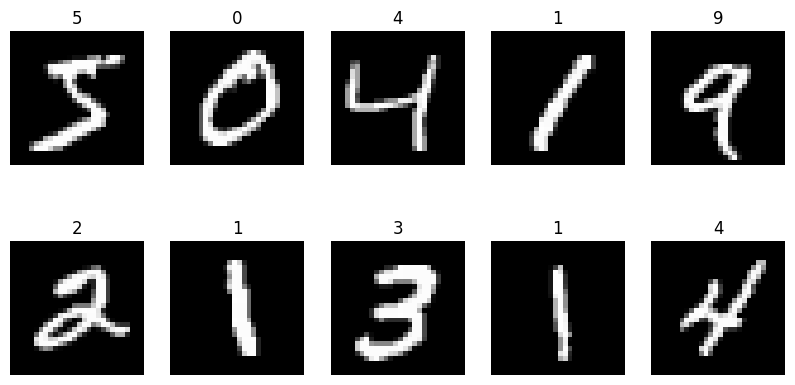

In [184]:
def plot_image(images, labels, rows, cols):
  fig = plt.figure(figsize=(10, 5))

  for i in range(rows*cols):
      img = images[i]
      ax = fig.add_subplot(rows, cols, i+1)
      ax.title.set_text(labels[i])
      plt.imshow(img.reshape((28,28, 1)), cmap='gray')
      plt.axis('off')
  plt.show()

rows = 2
cols = 5
images = X_train[:rows*cols]
labels = y_train[:rows*cols]
plot_image(images, labels, rows, cols)

In [185]:
EPOCHS = 5001
BATCH_SIZE = 128
SAVE_INTERVAL = 1000

In [186]:
def train_model():
    print(X_train.shape)

    valid = np.ones((BATCH_SIZE, 1))    
    fake = np.zeros((BATCH_SIZE, 1))

    losses = {"G": [], "D": []}

    images_test = np.random.normal(0, 1, (10, 100))  # mean 0, sd 1, no. of samples 10*100.
    labels_test = np.random.randint(0, 10, 10).reshape((-1, 1))   # randomly draw 10 ints from 0 to 9 with replacement.

    for epoch in range(EPOCHS):
        idx = np.random.randint(0, X_train.shape[0], BATCH_SIZE)
        real_imgs, labels = X_train[idx], y_train[idx]

        noise = np.random.normal(0, 1, (BATCH_SIZE, 100))
        fake_imgs = generator.predict([noise, labels])

        # train discriminator
        discriminator.trainable = True
        d_loss_real = discriminator.train_on_batch([real_imgs, labels], valid)
        d_loss_fake = discriminator.train_on_batch([fake_imgs, labels], fake)

        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)  # half of real loss + fake loss

        discriminator.trainable = False

        z = np.random.normal(0, 1, size=(BATCH_SIZE, 100))
        labels = np.random.randint(0, 10, BATCH_SIZE).reshape((-1, 1))

        # train generator
        g_loss = cgan.train_on_batch([z, labels], valid)

        losses["G"].append(g_loss)
        losses["D"].append(d_loss)

        if epoch % SAVE_INTERVAL == 0:
            print("Losses(d,g):", d_loss[0], g_loss[0])
            results = generator.predict([images_test, labels_test])
            plot_image(results, labels_test, 2, 5)
    
    return cgan, discriminator, generator


(60000, 28, 28, 1)
4/4 [==============================] - 0s 18ms/step
Losses(d,g): 0.7320210635662079 0.6122753620147705
1/1 [==============================] - 0s 121ms/step


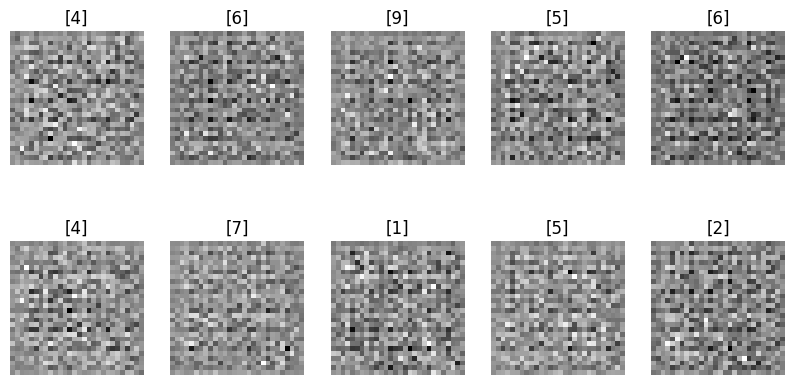

4/4 [==============================] - 0s 25ms/step
Losses(d,g): 0.6203041970729828 0.8307126760482788
1/1 [==============================] - 0s 37ms/step


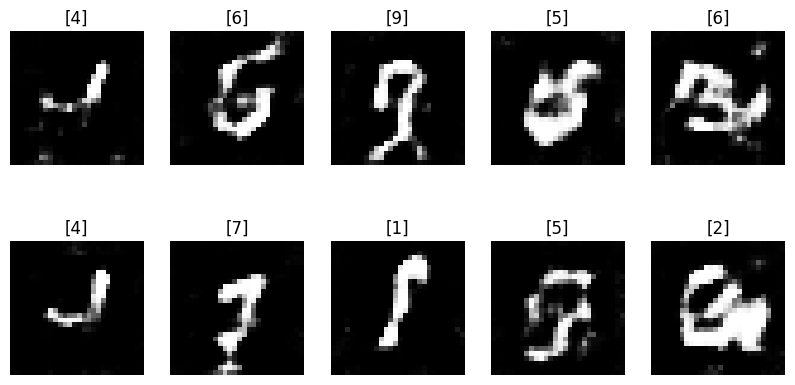

4/4 [==============================] - 0s 20ms/step
Losses(d,g): 0.6866170763969421 0.8478277921676636
1/1 [==============================] - 0s 28ms/step


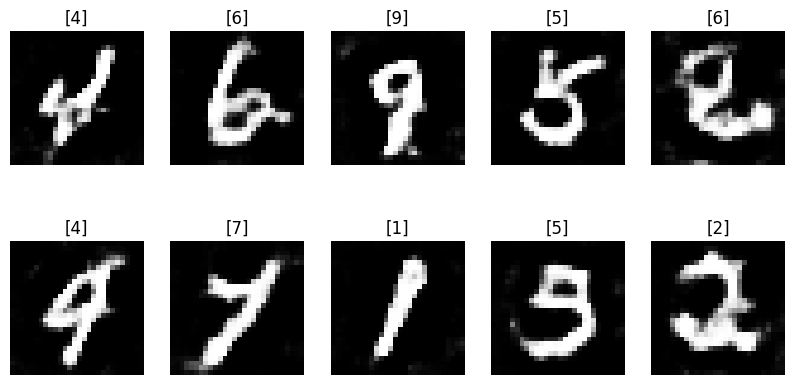

4/4 [==============================] - 0s 21ms/step
Losses(d,g): 0.6741991937160492 0.7850245237350464
1/1 [==============================] - 0s 33ms/step


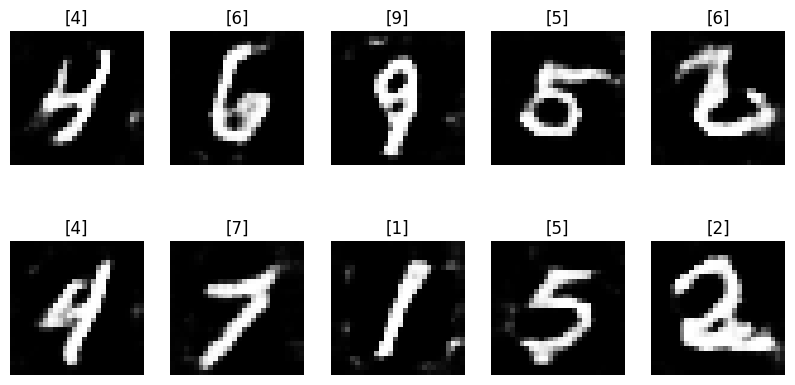

4/4 [==============================] - 0s 20ms/step
Losses(d,g): 0.6796688437461853 0.7659705281257629
1/1 [==============================] - 0s 24ms/step


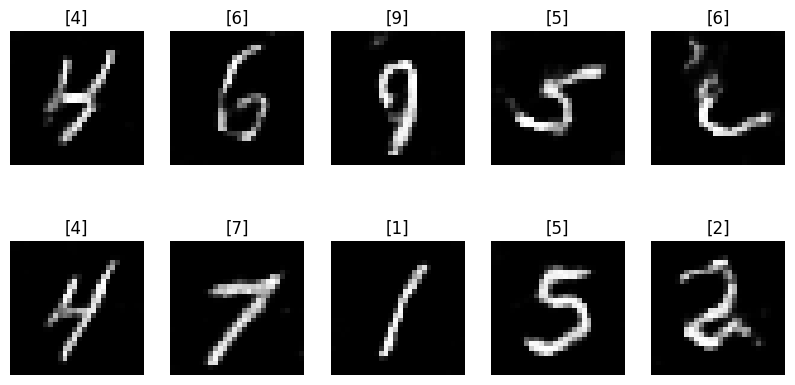

4/4 [==============================] - 0s 16ms/step
Losses(d,g): 0.6794989705085754 0.7650271654129028
1/1 [==============================] - 0s 24ms/step


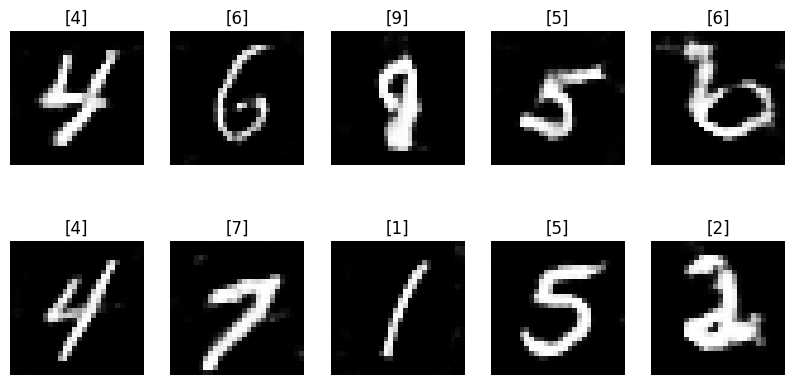

In [187]:
cgan, discriminator, generator = train_model()